In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.decomposition import PCA

from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings

****Dataset Description****
* <b>store_sales(in millions)</b> - store_sales(in million dollars)
* <b>unit_sales(in millions)</b> - unit_sales(in millions) in stores Quantity
* <b>Total_children</b> - TOTAL CHILDREN IN HOME
* <b>avg_cars_at home(approx)</b> - avg_cars_at home(approx)
* <b>Num_children_at_home</b> - num_children_at_home AS PER CUSTOMERS FILLED DETAILS
* <b>Gross_weight</b> - gross_weight OF ITEM
* <b>Recyclable_package</b> - FOOD ITEM IS recyclable_package
* <b>Low_fat</b> - FOOD ITEM IS LOW FAT
* <b>Units_per_case</b> - UNITS/CASE UNITS AVAILABLE IN EACH STORE SHELVES
* <b>Store_sqft</b> - STORE AREA AVAILABLE IN SQFT
* <b>Coffee_bar</b> - COFFEE BAR available in store
* <b>Video_store</b> - VIDEO STORE/gaming store available
* <b>Salad_bar</b> - SALAD BAR available in store
* <b>Prepared_food</b> - food prepared available in store
* <b>Florist</b> - flower shelves available in store
* <b>Cost - COST ON ACQUIRING A CUSTOMERS in dollars

In [2]:
# loading datasets
path = Path("/kaggle/input/playground-series-s3e11")

train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")
sub = pd.read_csv(path / "sample_submission.csv")


original_train = pd.read_csv("/kaggle/input/media-campaign-cost-prediction/train_dataset.csv")
original_test = pd.read_csv("/kaggle/input/media-campaign-cost-prediction/test_dataset.csv")
original = pd.concat([original_train, original_test])
original = original[train.drop('id', axis=1).columns]

# DATA OVERVIEW

In [3]:
# overall shapes
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} cols")
print(f"Test set has {test.shape[0]} rows and {test.shape[1]} cols")
print(f"original set has {original.shape[0]} rows and {original.shape[1]} cols")

Training set has 360336 rows and 17 cols
Test set has 240224 rows and 16 cols
original set has 60428 rows and 16 cols


In [4]:
# number of nulls in train and test set
null_train = train.isnull().sum().sum()
null_test = test.isnull().sum().sum()
null_original = original.isnull().sum().sum()

print(f"Number of nulls in train: {null_train}")
print(f"Number of nulls in test: {null_test}")
print(f"Number of nulls in original: {null_original}")

Number of nulls in train: 0
Number of nulls in test: 0
Number of nulls in original: 9065


In [5]:
# we need to remove the nulls
original.isnull().sum()

store_sales(in millions)         0
unit_sales(in millions)          0
total_children                   0
num_children_at_home             0
avg_cars_at home(approx).1       0
gross_weight                     0
recyclable_package               0
low_fat                          0
units_per_case                   0
store_sqft                       0
coffee_bar                       0
video_store                      0
salad_bar                        0
prepared_food                    0
florist                          0
cost                          9065
dtype: int64

In [6]:
original = original[~original['cost'].isnull()] # removing nulls

In [7]:
train_dtypes = train.dtypes.value_counts()
test_dtypes = test.dtypes.value_counts()
original_dtypes = original.dtypes.value_counts()

print("Training dataset: ", end='\n\n')
display(train_dtypes)
print("Test dataset: ", end='\n\n')
display(test_dtypes)
print('Original dataset: ', end='\n\n')
display(original_dtypes)

Training dataset: 



float64    16
int64       1
dtype: int64

Test dataset: 



float64    15
int64       1
dtype: int64

Original dataset: 



float64    16
dtype: int64

In [8]:
train_dup = train.drop(['cost', 'id'], axis=1).duplicated().sum()
test_dup = test.drop("id", axis=1).duplicated().sum()
original_dup = original.drop("cost", axis=1).duplicated().sum()


print(f"duplicates in train :{train_dup},  test :{test_dup} and original: {original_dup}")

duplicates in train :0,  test :0 and original: 541


In [9]:
# removing duplicates in original
original = original[~original.drop("cost", axis=1).duplicated()]

In [10]:
def summary(_df):
    """A function which summarizes the dataset given by giving us various statistical information"""
    summ = pd.DataFrame(_df.dtypes, columns=['data type'])
    summ['missing'] = _df.isnull().sum()
    summ['%missing'] = summ['missing'] / len(_df)
    summ['no_of_unique'] = _df.nunique()
    
    desc = _df.describe(include='all').transpose()
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['mean'] = desc['mean'].values
    summ['median'] = desc['50%'].values
    summ['first_value'] = _df.loc[0].values.flatten()
    summ['second_value'] = _df.loc[1].values.flatten()
    summ['third_value'] = _df.loc[2].values.flatten()
    
    return summ

train_summary = summary(train)
train_summary

,data type,missing,%missing,no_of_unique,min,max,mean,median,first_value,second_value,third_value
id,int64,0,0.0,360336,0.00,360335.00,180167.500000,180167.50,0.00,1.00,2.00
store_sales(in millions),float64,0,0.0,1044,0.51,22.92,6.337376,5.78,8.61,5.00,14.08
unit_sales(in millions),float64,0,0.0,6,1.00,6.00,3.043881,3.00,3.00,2.00,4.00
total_children,float64,0,0.0,6,0.00,5.00,2.456482,2.00,2.00,4.00,0.00
num_children_at_home,float64,0,0.0,6,0.00,5.00,0.689390,0.00,2.00,0.00,0.00
avg_cars_at home(approx).1,float64,0,0.0,5,0.00,4.00,2.203813,2.00,2.00,3.00,3.00
gross_weight,float64,0,0.0,384,6.00,21.90,13.822071,13.60,10.30,6.66,21.30
recyclable_package,float64,0,0.0,2,0.00,1.00,0.568086,1.00,1.00,1.00,1.00
low_fat,float64,0,0.0,2,0.00,1.00,0.327797,0.00,0.00,0.00,0.00
units_per_case,float64,0,0.0,36,1.00,36.00,18.972706,20.00,32.00,1.00,26.00


In [11]:
binary_feats = ['recyclable_package', 'low_fat', 'coffee_bar', "video_store", "salad_bar", "prepared_food", "florist"]
quan_feats = ['unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'units_per_case'
                , 'store_sqft']

print("In train")
for col in binary_feats+quan_feats:
    print(f'col {col} : {train[col].unique()}')
    
# print("In test")
# for col in binary_feats+quan_feats:
#     print(f'col {col} : {test[col].unique()}')
    
# print("In orginal")
# for col in binary_feats+quan_feats:
#     print(f'col {col} : {orginal[col].unique()}')

In train
col recyclable_package : [1. 0.]
col low_fat : [0. 1.]
col coffee_bar : [0. 1.]
col video_store : [0. 1.]
col salad_bar : [0. 1.]
col prepared_food : [0. 1.]
col florist : [0. 1.]
col unit_sales(in millions) : [3. 2. 4. 1. 5. 6.]
col total_children : [2. 4. 0. 5. 1. 3.]
col num_children_at_home : [2. 0. 5. 1. 4. 3.]
col avg_cars_at home(approx).1 : [2. 3. 0. 4. 1.]
col units_per_case : [32.  1. 26. 36. 20.  5.  6.  2.  9. 27.  4. 30. 23. 24. 13. 21. 12. 33.
 31.  7. 18.  3. 22. 25. 11. 17. 34. 10. 19. 14. 29. 16. 35. 28. 15.  8.]
col store_sqft : [36509. 28206. 21215. 27694. 33858. 23688. 38382. 30797. 20319. 23598.
 23112. 22478. 30584. 39696. 23759. 34791. 24597. 23593. 30268. 34452.]


So we have 13 features which are not continous we will convert them to integar.

In [12]:
for col in binary_feats+quan_feats:
    train[col] = train[col].astype('int32')
    
# test
for col in binary_feats+quan_feats:
    test[col] = test[col].astype('int32')   
#  orginal   
for col in binary_feats + quan_feats:
    original[col] = original[col].astype('int32')  

In [13]:
# new overall shapes
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} cols")
print(f"Test set has {test.shape[0]} rows and {test.shape[1]} cols")
print(f"original set has {original.shape[0]} rows and {original.shape[1]} cols")

Training set has 360336 rows and 17 cols
Test set has 240224 rows and 16 cols
original set has 50822 rows and 16 cols


# EDA

Before including original in our analysis we should check if distributions in original is the same as our train and test dataset for that we will use ****Adversarial Validation**** technique.

In [14]:
def adversarial_validation(train_df, test_df, classifier=LGBMClassifier(), n_splits=5, title='Roc curves', figsize=(6, 6)):
    """This is a function which checks if distribution between two datasets are same given the same columns. Then plots roc curve\
for each split. A score close to 0.5 means very similar"""
    
    train_df['target'] = 1  
    test_df['target'] = 0
    
    if len(train_df) > len(test_df):
        size = len(test_df)
    else:
        size = len(train_df)
    
    train_df = train_df.sample(size)
    test_df = test_df.sample(size)
    
    df = pd.concat([train_df, test_df]).sample(frac=1)
    
    X = df.drop('target', axis=1)
    y = df['target']
#     to code below is taken from sklearn documentaion of RocCurveDisplay with cross_validation
    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=figsize)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train_idx], y.iloc[train_idx])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[val_idx],
            y.iloc[val_idx],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{title}",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [ ]:
cols = train.drop(['id', 'cost'], axis=1).columns
adversariaal_validation(train[cols], test[cols], title="Roc curve between train and test", figsize=(5, 4))
adversarial_validation(train[cols], original[cols], title="Roc curve between train and original", figsize=(5, 4))
adversarial_validation(test[cols], original[cols], title="Roc curve between test and original", figsize=(5, 4))

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
It seems that the distibution in original and train dataset is very close. So we can try including it in our model training and see how it performs
    
</div>



## Target Distribution

In [ ]:
def plot_hist(df, x, x_label=None, title='Distribution', legend=None, **kwargs):
    '''Takes in a pandas dataframe and plot a histogram based on the feature name x provided'''
    ax = sns.histplot(data=df, x=x, **kwargs)
    if x_label:
        ax.set_xlabel(x_label)
    if legend:
        ax.legend(labels=[legend])
    ax.set_title(title)
    
def plot_box(df, x, x_label=None, title='Box plot', legend=None, **kwargs):
    '''Takes in a pandas dataframe and plot a boxplot on the feature name x provided'''
    ax = sns.boxplot(data=df, x=x, **kwargs)
    if x_label:
        ax.set_xlabel(x_label)
    if legend:
        ax.legend(labels=[legend])
    ax.set_title(title)
    
    
def plot_dist(df, x, axes, legend=None, **kwargs):
    """Takes in a pandas dataframe and plot histogram and box plot for given feature. You also have provide to axes"""
    plot_hist(df, x, x, legend=legend, ax=axes[0], kde=True, stat='density')
    plot_box(df, x, x, legend=legend, ax=axes[1])
    
def plot_line(df, x=None, y=None, title="Line plot", legend=None, **kwargs):
    "Takes in a pandas dataframe and plot a line plot for given x and y"
    ax = sns.lineplot(data=df, x=x, y=y, **kwargs)
    ax.set_title(title)
    if legend:
        ax.legend(labels=[legend])
    
def plot_categorical(df, x=None, y=None, title="Count plot", legend=None, **kwargs):
    "Takes in a pandas dataframe and plot countplot if y is not given and a violin plot if y is also given"
    if y:
        ax = sns.violinplot(df, x=x, y=y, **kwargs)
    else:
        ax = sns.countplot(data=df, x=x, **kwargs)
        
    ax.set_title(title)
    if legend:
        ax.legend(labels=[legend])

In [ ]:
nrows = 2
ncols = 2
target = "cost"
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*ncols))

plot_dist(train, target, ax[0], legend="train")
plot_dist(original, target, ax[1], legend="original")

plt.suptitle("Target distribution")
plt.tight_layout()

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
The distributions are almost same
    
</div>

## OTHER FEATURES

****Continous features****

In [ ]:
con_feats = ["store_sales(in millions)", "gross_weight", "units_per_case", "store_sqft"]
nrows = len(con_feats)
ncols = 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*ncols))

for i, col in  enumerate(con_feats):
    plot_hist(train, col, x_label=col, legend='train', title=None, ax=ax[i][0], kde=True)
    plot_hist(original, col, x_label=col, legend='orginal', title=None, ax=ax[i][1], kde=True)
    plot_hist(test, col, x_label=col, legend='test', title=None, ax=ax[i][2], kde=True)
    
plt.suptitle("Training, Original and Test continious featrues distribution")
plt.tight_layout()

In [ ]:
con_feats = ["store_sales(in millions)", "gross_weight", "units_per_case", "store_sqft"]
nrows = len(con_feats)
ncols = 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*ncols))

for i, col in  enumerate(con_feats):
    plot_box(train, col, x_label=col, legend='train', title=None, ax=ax[i][0])
    plot_box(original, col, x_label=col, legend='orginal', title=None, ax=ax[i][1])
    plot_box(test, col, x_label=col, legend='test', title=None, ax=ax[i][2])
    
plt.suptitle("Training, Original and Test continious features boxplot")
plt.tight_layout()

In [ ]:
con_feats = ["store_sales(in millions)", "gross_weight", "units_per_case", "store_sqft"]
nrows = len(con_feats)
ncols = 2
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*ncols))

for i, col in  enumerate(con_feats):
    _agg_train = train.groupby(col)[target].median().reset_index()
    _agg_original = train.groupby(col)[target].median().reset_index()
    plot_line(_agg_train, x=col, y=target, legend='train', title=None, ax=ax[i][0])
    plot_line(_agg_original, x=col, y=target, legend='original', title=None, ax=ax[i][1])
    
plt.suptitle("Releation between target and continous features(aggregated)")
plt.tight_layout()

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
The distributions are almost the same with little bit of difference but we can see that target changes dynamically with changes to feature values 
    
</div>

In [ ]:
binary_feats = ['recyclable_package', 'low_fat', 'coffee_bar', "video_store", "salad_bar", "prepared_food", "florist"]

nrows = len(binary_feats)
ncols = 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 5*ncols))

for i, col in  enumerate(binary_feats):
    plot_categorical(train, x=col, legend='train', title="Count plot ", ax=ax[i][0])
    plot_categorical(original, x=col, legend='orginal', title='Count plot', ax=ax[i][1])
    plot_categorical(test, x=col, legend='test', title='Count plot', ax=ax[i][2])
    
plt.suptitle("Training, Original and Test binary features Countplot")
plt.tight_layout()

In [ ]:
nrows = len(binary_feats)
ncols = 2
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 6*ncols))

for i, col in  enumerate(binary_feats):
    plot_categorical(train, x=col, y=target, title="Count plot ", ax=ax[i][0])
    plot_categorical(original, x=col, y=target, title='Count plot', ax=ax[i][1])
    
plt.suptitle("Training, Original and Test continious features boxplot")
plt.tight_layout()

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
The distributions of targets are different for 0 and 0 values in features but median are almost the same
    
</div>

In [ ]:
quan_feats = ['unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'units_per_case'
                , 'store_sqft']


nrows = len(quan_feats)
ncols = 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 5*ncols))

for i, col in  enumerate(quan_feats):
    plot_categorical(train, x=col, legend='train', title="Count plot ", ax=ax[i][0])
    plot_categorical(original, x=col, legend='orginal', title='Count plot', ax=ax[i][1])
    plot_categorical(test, x=col, legend='test', title='Count plot', ax=ax[i][2])
    
plt.suptitle("Training, Original and Test quan features Countplot")
plt.tight_layout()

In [ ]:
quan_feats = ['unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'units_per_case'
                , 'store_sqft']

nrows = len(quan_feats[:-2])
ncols = 2
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 6*ncols))

for i, col in  enumerate(quan_feats[:-2]):
    plot_categorical(train, x=col, y=target, title="Count plot ", ax=ax[i][0])
    plot_categorical(original, x=col, y=target, title='Count plot', ax=ax[i][1])
    
plt.suptitle("Training, Original and Test quantitive features boxplot")
plt.tight_layout()

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
The distributions of targets are different for 0 and 0 values in features but median are almost the same
    
</div>

## HEATMAP

In [ ]:
def plot_corr(df, features, target=None, method='pearson', figsize=(13, 8), use_mask=True, mask_type="triu", **kwargs):
    plt.figure(figsize=figsize) # sets figure size
    corr = train[features].corr(method=method) # calculates correlation based on the features and method provied
    
    if target: # if target feature name is provided then sort the correlation matrix
        corr = corr.sort_values(by=target)
    if use_mask: # if uses_mask = True
        if mask_type == 'triu': # sets mask type to lower trigonal
            mask = np.triu(np.ones(corr.shape)) 
        else:   # sets mask type to upper trigonal
            mask = np.tril(np.ones(corr.shape))
        sns.heatmap(corr, annot=True, mask=mask, **kwargs)
        
    else: # if uses mask is not true
         sns.heatmap(corr, annot=True, **kwargs)       

    plt.title('Correlation between features')

In [ ]:
corr_feats = train.drop('id', axis=1).columns.tolist()

plot_corr(train, corr_feats, target='cost', method='pearson', mask_type='tril', cmap='Greens')

In [ ]:
salad_food = train.pivot_table(values=['id', 'cost'], index='salad_bar', columns='prepared_food', aggfunc={'id':"size", 'cost':"mean"})

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.heatmap(salad_food['id'], annot=True, fmt='g', cmap='icefire')
plt.title("Number of occurence of salad_bar and prepared food ")

plt.subplot(1, 2, 2)
sns.heatmap(salad_food['cost'], annot=True, fmt='.2f', cmap='icefire')
plt.title("Mean cost with respect to salad_bar and prepared food ")
plt.tight_layout()

<div style='background-color: lightgreen; padding:8px'>
    
<b>Insigts: </b>
* Most stores either have both salad bar and prepared food or do not have them both. In both of these cases the mean cost is high. 
* For stores which only salad bar or prepared food has lower media campaign cost
* We can create a new feature to capture these releations
</div>

## PCA

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=12, dpi=100)
    return axs

In [ ]:
def plot_pca(df):
    """Takes a dataset and do pricinpal component analysis and plots the results"""
#     The code below is mostly taken from kaggle learn course Principal Component Analysis. Link is below
# https://www.kaggle.com/code/ryanholbrook/principal-component-analysis#Example---1985-Automobiles
    _X = df.copy()
    features = _X.columns.tolist()

    # Standardize
    X_scaled = (_X - _X.mean(axis=0)) / _X.std(axis=0)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=_X.columns,  # and the rows are the original features
    )
    
    display(loadings)
    plot_variance(pca)

In [ ]:
plot_pca(train.drop(['id', 'cost'], axis=1))

# Basic Modeling

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


from functools import partial

models = {
    "LinearRegression": partial(LinearRegression),
    "Ridge": partial(Ridge, random_state=0),
    "Lasso": partial(Lasso, random_state=0),
#     "ElasticNet": partial(ElasticNet, random_state=0),
#     "RandomForestRegressor": partial(RandomForestRegressor, random_state=0),
#     "AdaBoostRegressor": partial(AdaBoostRegressor, random_state=0), 
#     "GradientBoostRegressor": partial(GradientBoostingRegressor, random_state=0),
#     "HistGradientBoostingRegressor":  partial(HistGradientBoostingRegressor, random_state=0),
#     "ExtraTreesRegressor": partial(ExtraTreesRegressor, random_state=0),
    "XGBoostRegressor": partial(XGBRegressor, tree_method='gpu_hist', random_state=0),
    "CatBoostRegressor": partial(CatBoostRegressor, random_state=0, verbose=False, task_type="GPU"),
    "LGBMRegressor": partial(LGBMRegressor, random_state=0, device='gpu'),
#     "KNeighborsRegressor": partial(KNeighborsRegressor),
#     "SVR": partial(SVR),
}

In [ ]:
class Splitter:
#     code from https://www.kaggle.com/code/tetsutani/ps3e9-eda-and-gbdt-catboost-median-duplicatedata wit little bit of modification
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold 
        self.n_splits= n_splits
        
    def split_data(self, X, y, random_state):
        if self.kfold:
            kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_idx, val_idx in kf.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                y_train = np.log(y_train) # for rmsle only
                y_val = np.log(y_val)
                yield X_train, X_val, y_train, y_val, train_idx, val_idx
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
            yield X_train, X_val, y_train, y_val
        
        
def evaluate_model(model_name, model, _X, _y, gbdt=True, n_splits=5, random_state_list=[0, 5, 10]):
    len_y = len(_y)
    len_states = len(random_state_list)

    oof_preds = np.zeros(len_y * len_states).reshape(len_states, len_y)
    models = []
    scores_train = []
    scalers = []
    for index, random_state in enumerate(random_state_list):
        print("#"*25)
        print("#"*15, f"traininng model {model_name} with seed {random_state}")
        print("#"*25)
        splitter = Splitter(n_splits=n_splits)
        splits = 0
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, random_state):
            _model = model()
            if not gbdt:  
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                scalers.append(deepcopy(scaler))
            
            _model.fit(X_train, y_train)
            oof_preds[index, val_idx] = _model.predict(X_val).squeeze()
            models.append(deepcopy(_model))

            score_train = root_mean_squared_log_error(y_train, _model.predict(X_train))
            scores_train.append(score_train)

            score_valid_split = root_mean_squared_log_error(y_val, _model.predict(X_val).squeeze())

            print(f"seed {random_state} and split {splits} score {score_valid_split}")
            splits += 1

    oof_preds_mean = oof_preds.mean(axis=0)

    return models, oof_preds_mean, np.mean(scores_train), root_mean_squared_log_error(np.log(y), oof_preds_mean), scalers
        
        

def root_mean_squared_log_error(y_true_log, y_pred_log):
    return mean_squared_error(y_true_log, y_pred_log, squared=False)


def predict_test(models, X_test, scalers=None, gbdt=True, n_splits=5, n_repeats=3):
    test_preds = np.zeros(n_splits * n_repeats * len(X_test)).reshape(n_splits * n_repeats, len(X_test))
    X_test_ = X_test.copy()
    for index, model in enumerate(models):
        if not gbdt:
            X_test_ = scalers[index].transform(X_test) # normally you would not do ensembling for linear models 
        preds = model.predict(X_test_)                 # if we have a lot of observations we can do that if we want
        test_preds[index, range(len(preds))] = preds
        
    return test_preds


def submission_csv(predictions, target='cost'):
    df = pd.DataFrame()
    df['id'] = test['id']
    df[target] = np.exp(predictions) # exp only for this rmsle
    
    return df

def dump_model(models_log, model_name, train_score, valid_score):
    info = {'Model name': model_name, 'Local cv train score': train_score,
               "Local cv valid score": valid_score}
            
    models_log = models_log.append(info, ignore_index=True)
    
    return models_log

In [ ]:
models_log = pd.DataFrame(columns=['Model name', 'Local cv train score', "Local cv valid score"])

In [ ]:
X = train.drop(['id', 'cost', 'salad_bar'], axis=1)
y = train['cost']

In [ ]:
# got the score below after running the code in this cell
tree_models = ["RandomForestRegressor", "AdaBoostRegressor", "GradientBoostRegressor", "HistGradientBoostingRegressor",
               "ExtraTreesRegressor", "CatBoostRegressor", "LGBMRegressor"]

n_splits = 10
random_state_list = [0, 5, 10]
n_repeats = len(random_state_list)
trained_models = {}
oof_predictions = {}
scalers = {}
gbdt = False

for model_name, model in models.items():   
    if model_name in tree_models:
        gbdt=True
    else:
        gbdt=False
    _models, _oof_preds, mean_train_score, mean_valid_score, _scalers = evaluate_model(model_name, model, X, y, gbdt=gbdt, 
                                                                            n_splits=n_splits, random_state_list=random_state_list) 
    
    trained_models[model_name+"_default"] = _models
    scalers[model_name+"_default"] = _scalers
    oof_predictions[model_name+"_default"] = _oof_preds.mean(axis=0)
    models_log = dump_model(models_log, model_name,  mean_train_score, mean_valid_score) 


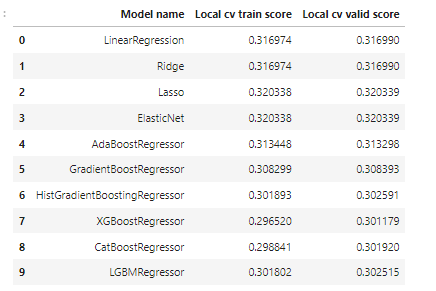

In [ ]:
models_log

In [ ]:
models_log.to_csv("models_default_scores.csv", index=False)

In [ ]:
model_preds = {}

for model_name, model in models.items():   
    if model_name in tree_models:
        gbdt=True
    else:
        gbdt=False
    
    preds = predict_test(trained_models[model_name+"_default"], test.drop(['id', "salad_bar"], axis=1), 
                         scalers=scalers[model_name+"_default"], gbdt=gbdt, n_splits=n_splits, n_repeats=n_repeats)
    
    model_preds[model_name + "_default"] = preds.mean(axis=0)
    print(model_name)

In [ ]:
for model_name, preds in model_preds.items():
    _df = submission_csv(preds)
    _df.to_csv(f"{model_name}_defualt.csv", index=False)